# Linear classifier on bottleneck features from pretrained Xception model.



In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from PIL import Image

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from matplotlib import pyplot
import seaborn as sns

Using TensorFlow backend.


In [2]:
# Specifying train, validation and test set
path = "/home/ubuntu/nbs/data/balanced_augmented_seedlings"
train_path = os.path.join(path, "train_augm")
valid_path = os.path.join(path, "valid_augm")
#test_path = os.path.join(path, "test")
preview_path = os.path.join(path, "preview")
checkpoint_path = os.path.join(path, "best_weights.hdf5")


In [3]:
# Get batches from the dirname directory and return batch genarator object.
def get_batches(dirname, shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(299,299)):
    gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
    flow = gen.flow_from_directory(
                        dirname, 
                        shuffle=False,
                        batch_size=batch_size, 
                        class_mode='categorical',
                        target_size=target_size,
                        )

    return flow 


In [4]:
batch_size = 64
train_batches_gen = get_batches(train_path, batch_size=batch_size)
valid_batches_gen = get_batches(valid_path, batch_size=batch_size)
for cl in train_batches_gen.class_indices.keys():
    print(cl)

Found 3000 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Cleavers
Maize
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Common wheat
Black-grass
Sugar beet
Charlock
Scentless Mayweed
Shepherds Purse
Fat Hen


In [5]:
# Using Xception model as feature extractor.
model = Xception(weights='imagenet', include_top=False, pooling='avg')

train_features = model.predict_generator(train_batches_gen)#, steps=5000/batch_size)
valid_features = model.predict_generator(valid_batches_gen)#, steps=1200/batch_size)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'w'), train_features)
np.save(open('bottleneck_features_valid.npy', 'w'), valid_features)

print('Inception train bottleneck features shape: {} size: {:,}'.format(train_features.shape, train_features.size))
print('Inception valid bottleneck features shape: {} size: {:,}'.format(valid_features.shape, valid_features.size))


Inception train bottleneck features shape: (3000, 2048) size: 6,144,000
Inception valid bottleneck features shape: (1200, 2048) size: 2,457,600


## Logistic Regression Classifier

In [6]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(train_features, train_batches_gen.classes)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

valid_preds = logreg.predict(valid_features)
print('Validation Accuracy {}'.format(accuracy_score(valid_batches_gen.classes, valid_preds)))
print('F1 score {}'.format(f1_score(valid_batches_gen.classes, valid_preds)))



Validation Accuracy 0.900833333333
F1 score 0.899889176276


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


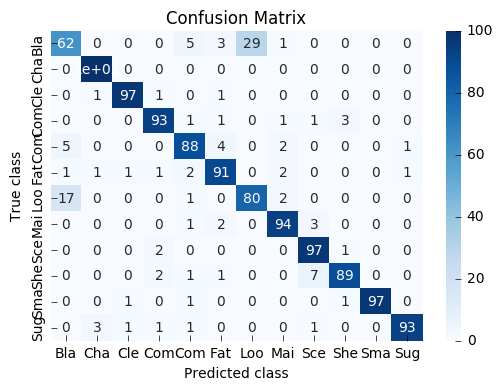

In [7]:
cnf_matrix = confusion_matrix(valid_batches_gen.classes, valid_preds)
fig, ax = pyplot.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=pyplot.cm.Blues, annot=True)
categories = [cat[:3] for cat in sorted(train_batches_gen.class_indices.keys())]
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
pyplot.title('Confusion Matrix')
pyplot.ylabel('True class')
pyplot.xlabel('Predicted class')
pyplot.show();


In [10]:
train_batches_gen.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

## SVM.LinearSVC

In [8]:

#train_features = np.load(open('bottleneck_features_train.npy'))
clf = LinearSVC(multi_class='crammer_singer')
clf.fit(train_features, train_batches_gen.classes) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [9]:
valid_preds = clf.predict(valid_features)
print('Validation Accuracy {}'.format(accuracy_score(valid_batches_gen.classes, valid_preds)))
print('F1 score {}'.format(f1_score(valid_batches_gen.classes, valid_preds)))


Validation Accuracy 0.8925
F1 score 0.891168026107


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


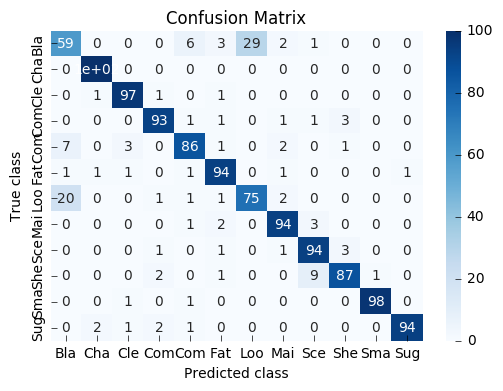

In [10]:
cnf_matrix = confusion_matrix(valid_batches_gen.classes, valid_preds)
fig, ax = pyplot.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=pyplot.cm.Blues, annot=True)
categories = [cat[:3] for cat in sorted(train_batches_gen.class_indices.keys())]
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
pyplot.title('Confusion Matrix')
pyplot.ylabel('True class')
pyplot.xlabel('Predicted class')
pyplot.show();
